In [ ]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import os
os.chdir('/data/project/AI4Omic/MASLD/data/scRNA')

sc.settings.set_figure_params(dpi=300, dpi_save=300)
sc.settings.figdir = '/data/project/AI4Omic/MASLD/results/scRNA/preprocessing'

In [ ]:
import os
os.chdir('/data/project/AI4Omic/MASLD/data/scRNA')

In [ ]:
# Define sample names
clinical_info = pd.read_csv('/data/project/AI4Omic/MASLD/results/scRNA/preprocessing/clinical_info.csv')
# Required by reviewers during the minor revision
clinical_info = clinical_info[clinical_info['sample'] != 'CTRL-184']
samples = list(clinical_info['sample'])


# Define centrifugation
Centrifugation = ['PCs'] * len(clinical_info) + ['NPC'] * len(clinical_info)

# Create directory names
dir_names = [f"{sample}-Hepa_matrix" for sample in samples] + [f"{sample}_matrix" for sample in samples]

# Clinical information
# Initialize list to hold AnnData objects
scRNAlist = []


# Loop through directory names, read data and create AnnData objects
for i, dir_name in enumerate(dir_names):
    adata = sc.read_10x_mtx(dir_name, var_names="gene_symbols", cache=False)  # Create AnnData object
    adata.var_names_make_unique()  # Make gene names unique
    
    # Add metadata
    adata.obs['sample'] = (samples * 2)[i]
    adata.obs['disease_status'] = adata.obs['sample'][0].split('-')[0]
    adata.obs['Centrifugation'] = Centrifugation[i]
    adata.obs['orig.ident'] = dir_name.replace('_matrix', '')

    # clinical data
    adata.obs['Age'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Age'].values[0]
    adata.obs['Sex'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Sex'].values[0]
    adata.obs['Steatosis'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Steatosis'].values[0]
    adata.obs['Ballooning'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Ballooning'].values[0]
    adata.obs['Lobular_inflammation'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Lobular_inflammation'].values[0]
    adata.obs['Fibrosis'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Fibrosis'].values[0]
    adata.obs['NAS'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'NAS'].values[0]
    
    # make barcodes unique for each sample
    adata.obs_names = [dir_name.replace('_matrix', '') + '_' + barcode for barcode in adata.obs_names]
    
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)(E)]")
    
    # quality control calculations
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    sc.pp.filter_genes(adata, min_cells=3, inplace=True)
    
    scRNAlist.append(adata)

/tmp/ipykernel_3573880/3420187427.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs['disease_status'] = adata.obs['sample'][0].split('-')[0]
/tmp/ipykernel_3573880/3420187427.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs['Age'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Age'].values[0]
/tmp/ipykernel_3573880/3420187427.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ada

In [23]:
# Merge AnnData objects
adata = sc.concat(scRNAlist, label='orig.ident', keys=[name.replace('_matrix', '') for name in dir_names], join='outer', fill_value=0)

In [10]:
adata

AnnData object with n_obs × n_vars = 667445 × 35258
    obs: 'sample', 'disease_status', 'Centrifugation', 'orig.ident', 'Age', 'Sex', 'Steatosis', 'Ballooning', 'Lobular_inflammation', 'Fibrosis', 'NAS', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'

In [25]:
# Order factors (sample/group)
adata.obs['disease_status'] = pd.Categorical(adata.obs['disease_status'], categories=['CTRL', 'MASL', 'MASH'], ordered=True)
adata.uns['disease_status_colors'] = ['#a6cee3', '#fdbf6f', '#b15928']
adata.obs['sample'] = pd.Categorical(adata.obs['sample'], ordered=True, categories=samples)

In [ ]:
adata.obs['orig.ident'].value_counts()

In [ ]:
# Violin QC plot before filtering
import matplotlib.pyplot as plt
with plt.rc_context({'xtick.labelsize': 6.5, 'ytick.labelsize': 7, 'axes.labelsize': 9}): # , "figure.figsize": (10, 5)
    sc.pl.violin(adata,
                 keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
                 groupby='sample', 
                 jitter=False, 
                 rotation=90,
                 show=True,
                 save='QC_before_scRNA-seq.png',
                 )

In [ ]:
# Source data
adata.obs[['sample', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt']].to_csv('/data/project/AI4Omic/MASLD/source_data/Extended_data_figs/Extended_Data_Fig1a.csv')

In [13]:
# doublets removal
cell_num_preqc = dict(adata.obs['orig.ident'].value_counts())
sc.pp.scrublet(adata, batch_key='orig.ident', n_neighbors=10, expected_doublet_rate=0.10)
adata = adata[~adata.obs.predicted_doublet, :] # 667445 -> 659329 
adata

View of AnnData object with n_obs × n_vars = 659329 × 35258
    obs: 'sample', 'disease_status', 'Centrifugation', 'orig.ident', 'Age', 'Sex', 'Steatosis', 'Ballooning', 'Lobular_inflammation', 'Fibrosis', 'NAS', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    uns: 'disease_status_colors', 'scrublet'

In [14]:
# Subset AnnData object based on quality control metrics
# Moderate filtering criteria (Before Minor Revision):
adata = adata[(adata.obs['pct_counts_mt'] < 30) & (adata.obs['pct_counts_hb'] < 1) & (adata.obs['total_counts'] > 500) & (adata.obs['n_genes_by_counts'] > 250) & (adata.obs['total_counts'] < 50000) & (adata.obs['pct_counts_ribo'] < 30)]

# Stricter filtering criteria (After Minor Revision):
adata = adata[(adata.obs['n_genes_by_counts'] < 6000)  & (adata.obs['total_counts'] < 40000)] # cite Nature literature 《Acquisition of epithelial plasticity in human chronic liver disease》

cell_num_postqc = dict(adata.obs['orig.ident'].value_counts())
removal_percentage = {key: 100 *(cell_num_preqc[key] - cell_num_postqc[key]) / cell_num_preqc[key] for key in cell_num_preqc.keys()}
QC_summary = pd.DataFrame({'Pre-QC': cell_num_preqc, 'Post-QC': cell_num_postqc, 'Removal percentage': removal_percentage})
QC_summary

,Pre-QC,Post-QC,Removal percentage
MASH-5846,25693,25093,2.335266
MASH-5846-Hepa,20754,19671,5.218271
CTRL-5759,18464,17267,6.482886
MASH-8461-Hepa,18327,16190,11.660392
MASH-8461,17945,17033,5.082196
MASH-4366,17662,17029,3.583966
MASH-1531-Hepa,17238,16618,3.596705
MASH-1486,17219,16478,4.303386
CTRL-8715,16388,15486,5.504027
MASL-1483,16142,15501,3.971007


In [ ]:
QC_summary.to_csv('/data/project/AI4Omic/MASLD/source_data/Extended_data_figs/QC.csv')

In [ ]:
# Violin QC plot after filtering
import matplotlib.pyplot as plt
with plt.rc_context({'xtick.labelsize': 6.5, 'ytick.labelsize': 7, 'axes.labelsize': 9}): # , "figure.figsize": (10, 5)
    sc.pl.violin(adata,
                 keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
                 groupby='sample',
                 jitter=False,
                 rotation=90,
                 show=True,
                 save='QC_after_scRNA-seq.png',
                 )

In [57]:
# Normalization
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
#adata.layers['logcounts'] = adata.X.copy()

# Batch effect Correction
sc.pp.highly_variable_genes(adata, n_top_genes=6000, batch_key="sample", flavor='seurat_v3')
adata.var.loc[(adata.var.index.str.startswith('IGLV')) | (adata.var.index.str.startswith('IGKV')) | (adata.var.index.str.startswith('IGHV')) | (adata.var.index.str.startswith('IGLC')) | (adata.var.index.str.startswith('IGKC')), 'highly_variable'] = False
#sc.pp.regress_out(adata, ["total_counts", 'pct_counts_mt'], n_jobs=40)
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'orig.ident', max_iter_harmony=30)

# Dimensional reduction
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, use_rep='X_pca_harmony')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1.5)

/tmp/ipykernel_4109312/3977628183.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()
/home/bailab/miniconda3/envs/Visium_HD/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
2025-04-10 20:21:41,546 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-10 20:22:16,923 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-10 20:22:19,651 - harmonypy - INFO - Iteration 1 of 30
2025-04-10 20:26:48,603 - harmonypy - INFO - Iteration 2 of 30
2025-04-10 20:31:21,914 - harmonypy - INFO - Iteration 3 of 30
2025-04-10 20:35:44,379 - harmonypy - INFO - Iteration 4 of 30
2025-04-10 20:38:06,448 - harmonypy - INFO - Converged after 4 iterations
/home/bailab/miniconda3/envs/Visium_HD/lib/python3.12/site-packages/tqdm/auto.py:21: 

In [171]:
sc.tl.leiden(adata, resolution=1.2, flavor='igraph', n_iterations=3)

In [29]:
#sc.tl.leiden(adata, resolution=0.2, restrict_to=('leiden', ['15', '23', '25']))
sc.tl.leiden(adata, resolution=0.3, restrict_to=('leiden', ['14']), flavor='igraph', n_iterations=6)

In [ ]:
sc.pl.umap(adata, color=['leiden'], ncols=2, sort_order=False, legend_loc='on data', palette='tab20', frameon=False, legend_fontsize=6)

In [ ]:
sc.pl.umap(adata, color=['leiden'], ncols=2, sort_order=False, legend_loc='on data', palette='tab20', frameon=False, legend_fontsize=6)

In [ ]:
sc.pl.umap(adata, color=['CMTM2', 'SPP1', 'ACTA2', 'MITF', 'TREM2', 'CD1C', 'LPL', 'CD5L', 'TIMD4', 'CLEC9A', 'IDO1', 'CD14', 'FCGR3A', 'IGHG1', 'IGHA1', 'SDC1', 'total_counts', 'CD3E', 'SLC4A10'])

In [ ]:
title_size = 8
fig, axs = plt.subplots(6, 6, figsize=(12, 12), gridspec_kw={'wspace':0.3, 'hspace':0.1})
for si in range(len(samples)):
    _sc_0 = sc.pl.umap(adata[adata.obs['sample'] == samples[si]], color=['SPP1'], size=1.6, legend_fontsize=8, show=False, frameon=False, ax=axs[si//6, si%6], legend_loc='on data')
    _sc_0.set_title(f'{samples[si]}', fontsize=title_size)
plt.show()
#plt.savefig('/data/project/AI4Omic/NAFLD/results/ST/STAligner/spatialdimplot-16samples.pdf', bbox_inches='tight', dpi=300)

In [ ]:
sc.pl.umap(adata, color=['SLCO2A1', 'MECOM', 'FLRT2', 'PODXL', 'STAB2', 'JAG1', 'RSPO3', 'PTGS1', 'VWF', 'PLCXD3'])

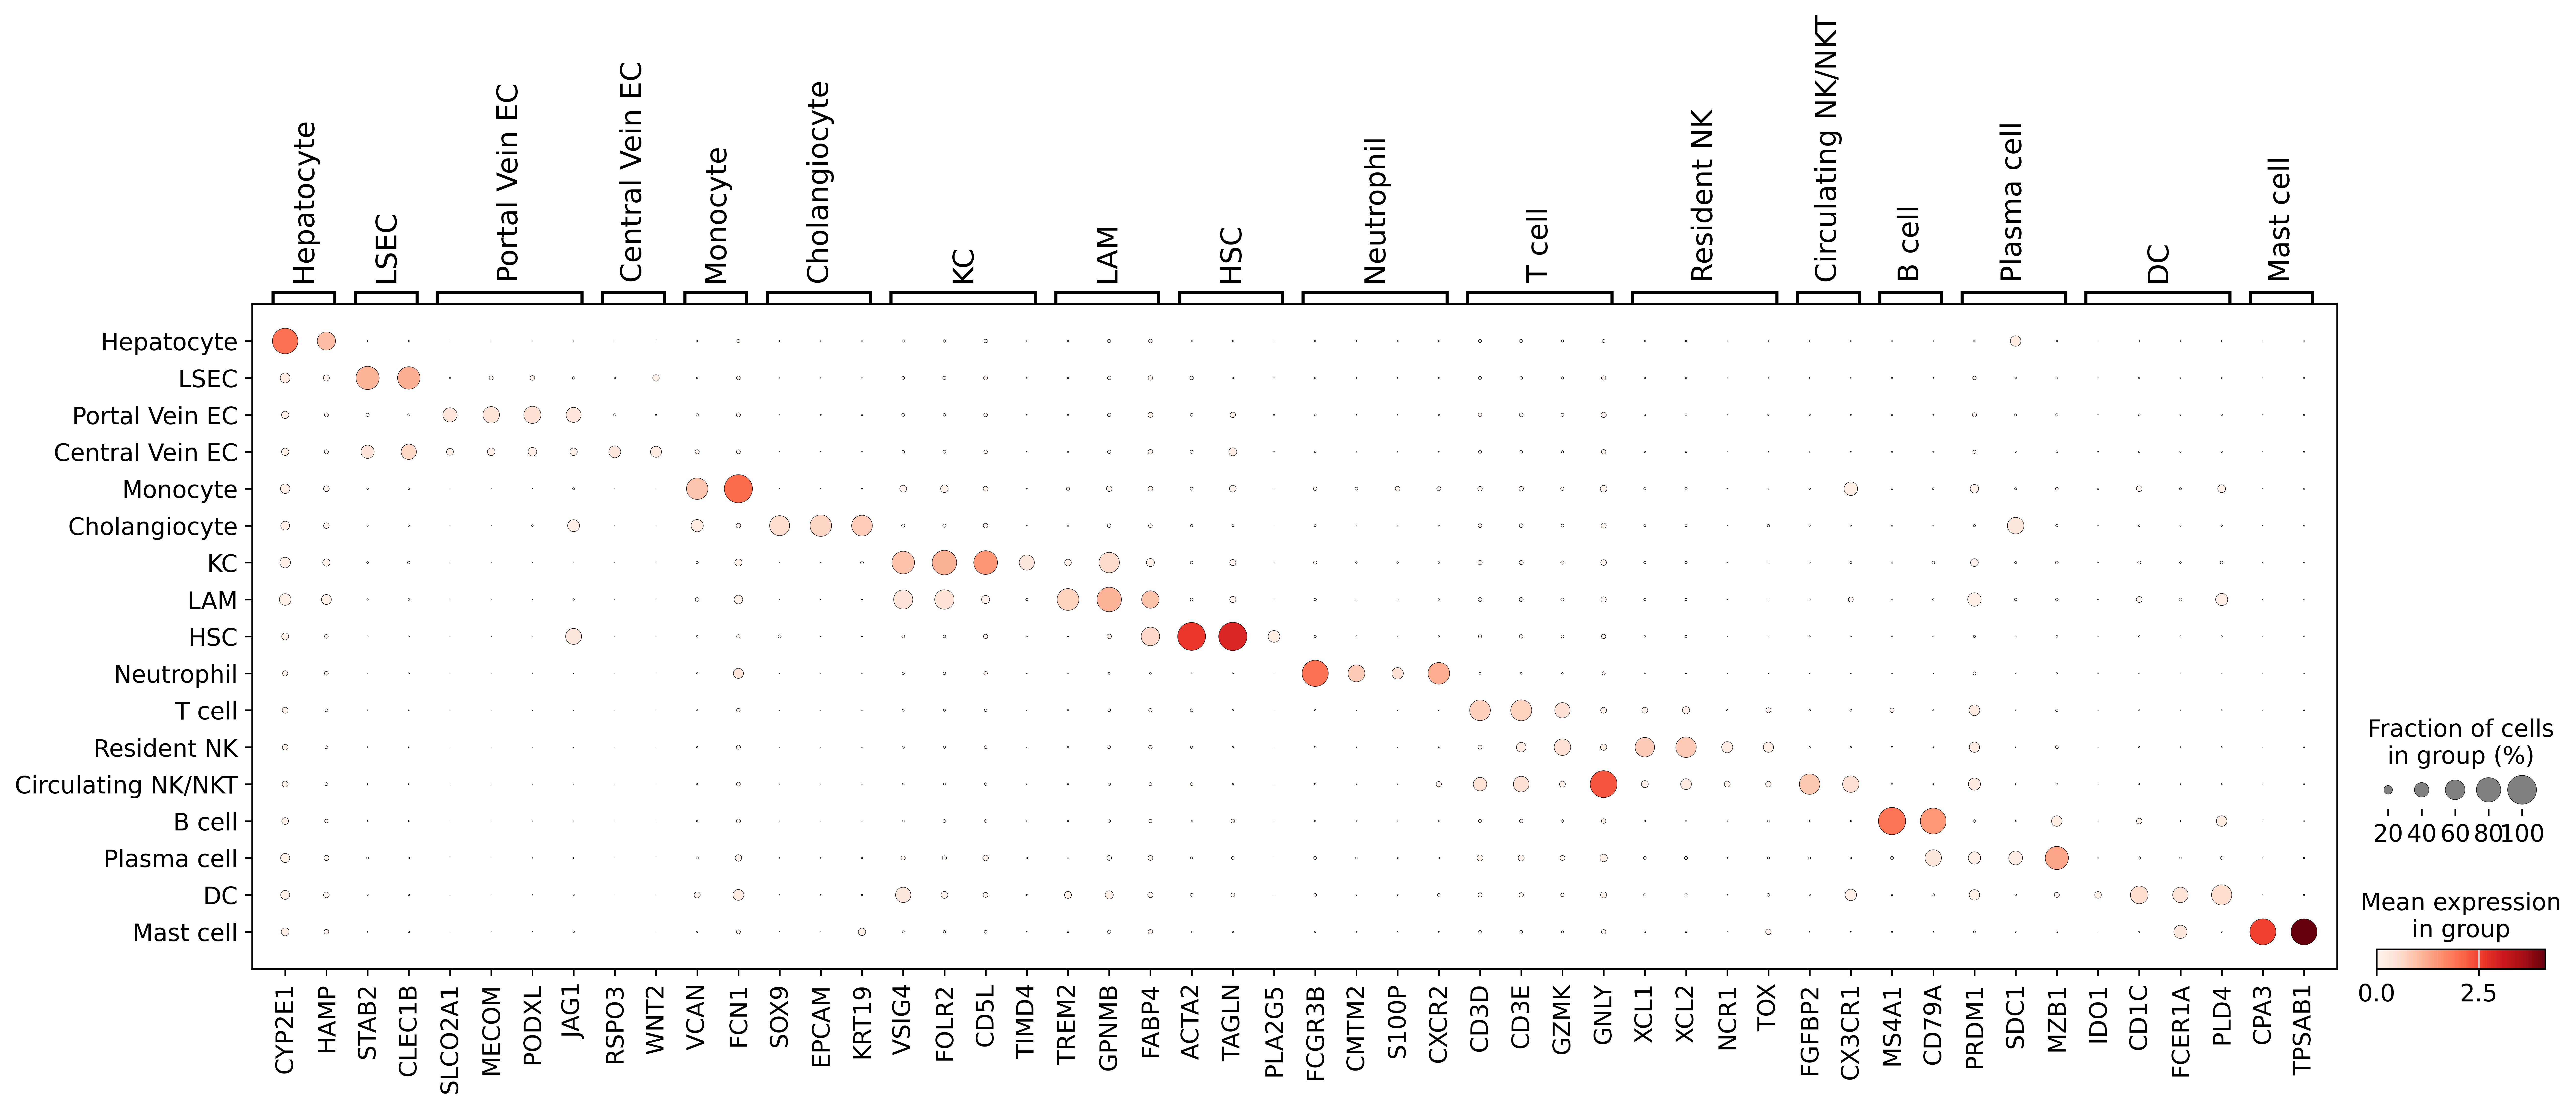

In [118]:
# Marker List
marker_genes_dict = {
    'Hepatocyte': ['CYP2E1', 'HAMP'],
    'LSEC': ['STAB2','CLEC1B'],
    'Portal Vein EC': ['SLCO2A1', 'MECOM', 'PODXL', 'JAG1'],
    'Central Vein EC': ['RSPO3', 'WNT2'],
    'Monocyte': ['VCAN','FCN1'],
    'Cholangiocyte': ['SOX9','EPCAM','KRT19'],
    'KC': ['VSIG4', 'FOLR2', 'CD5L', 'TIMD4'], #, 'CLEC4F', 'CCR2'
    'LAM': ['TREM2','GPNMB', 'FABP4'],
    'HSC': ['ACTA2','TAGLN', 'PLA2G5'],
    'Neutrophil': ['FCGR3B', 'CMTM2', 'S100P', 'CXCR2'], #'CSF3R'
    'T cell': ['CD3D', 'CD3E','GZMK','GNLY'],
    'Resident NK': ['XCL1', 'XCL2', 'NCR1', 'TOX'],
    'Circulating NK/NKT': ['FGFBP2', 'CX3CR1'],
    'B cell': ['MS4A1','CD79A'],
    'Plasma cell': ['PRDM1', 'SDC1', 'MZB1'],
    'DC': ['IDO1', 'CD1C', 'FCER1A', 'PLD4'],
    'Mast cell': ['CPA3', 'TPSAB1']
}
adata.obs.cell_type_lvl1 = pd.Categorical(adata.obs.cell_type_lvl1, categories=marker_genes_dict.keys(), ordered=True)
#sc.pl.dotplot(adata,marker_genes_dict, 'celltype', dendrogram=False, cmap='Blues', save='Marker_Dotplot.pdf')
#sc.pl.stacked_violin(adata, immune_cell_markers, groupby="leiden")
sc.pl.dotplot(adata, marker_genes_dict, groupby="cell_type_lvl1", save='Marker_cell_type_lvl1.pdf', swap_axes=False)

In [ ]:
# remove low quaility cells by leiden clusters
adata.X = adata.layers['counts'].copy()
#adata = adata[~adata.obs.leiden.isin(['13', '19', '22', '23', '28', '29', '30', '31', '32', '33', '34', '35'])].copy() # 642572 -> 592539
#adata = adata[~adata.obs.leiden.isin(['17', '25', '27'])].copy() # 592539 -> 579588
#adata = adata[~adata.obs.leiden.isin(['16', '22', '28', '29', '30', '31', '32'])] # 579588 -> 558791
#adata = adata[~adata.obs.leiden_R.isin(['15-23-25,3', '15-23-25,4', '15-23-25,5'])] # 558791 -> 556841

In [74]:
# Celltype annotation (master level)
adata.obs["cell_type_lvl1"] = adata.obs["leiden"].map(
    {
        "0": "Neutrophil",
        "1": "Monocyte",
        "2": "Plasma cell",
        "3": "DC",
        "4": "T cell",
        "5": "T cell",
        "6": "Circulating NK/NKT",
        "7": "T cell",
        "8": "KC",
        "9": "Circulating NK/NKT",
        "10": "Resident NK",
        "11": "LAM",
        "12": "DC",
        "13": "Cholangiocyte",
        "14": "LSEC", # liver sinusoidal endothelial cells
        "15": "Portal Vein EC", # liver vascular endothelial cells
        "16": "T cell",
        "17": "Hepatocyte",
        "18": "Plasma cell", 
        "19": "B cell",
        "20": "HSC", 
        "21": "Mast cell", 
    }
)
adata.obs.loc[adata.obs.leiden_R == '14,1', "cell_type_lvl1"] = 'Central Vein EC'
adata.obs.loc[(adata.obs.cell_type_lvl1 == 'Portal Vein EC') & (adata[:, 'RSPO3'].X > 0.5).toarray().flatten(), 'cell_type_lvl1'] = 'Central Vein EC'

In [ ]:
# Fig. 1c
cell_type_lvl1_palette={
    "Neutrophil": "#DAC3C3",
    "Monocyte": "#d2af55",
    'B cell': "#DDEFFF",
    "Plasma cell": "#7cb6de",
    "DC": "#f9db85",
    "T cell": "#F4C4F4",
    "Circulating NK/NKT": "#f5b1bf",
    "Resident NK": "#c057a0",
    "LAM": "#f4b5a0",
    "KC": "#a23a26",
    "Cholangiocyte": "darkgreen",
    "LSEC": "#BAB0AC",
    "Portal Vein EC": "#ff7f0e",
    "Central Vein EC": "#E2E8A7",
    "Hepatocyte": "#A36F56",
    "HSC": "#9467bd",
    "Mast cell": "#8c564b"
}
sc.pl.umap(adata, color=['cell_type_lvl1'], legend_loc='on data', legend_fontsize=3.5, frameon=False, title='', palette=cell_type_lvl1_palette, save='cell_type_lvl1')

In [ ]:
# Source Data preparation
#adata.obs.to_csv('scRNA-seq_metadata.csv')
#adata.X.toarray().tofile('scRNA-seq_data.csv', sep=',')

In [ ]:
# Save and Load adata object
#adata = adata[:, ~adata.var_names.str.startswith('RF0')]
adata.write('/data/project/AI4Omic/MASLD/results/scRNA/preprocessing/adata_29samples.h5ad')